In [1]:
import sys
import pickle
sys.path.insert(0,'..')

from causalmodel.interference import Clustered
from causalmodel.utils.random_data import get_data, get_clustered_data
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [5]:
def one_trial():
    Y, Z, X, labels = get_clustered_data(Ms=[5000,5000,2000], ns=[2,3,5])
    c = Clustered(Y, Z, X, labels)
    result = c.est_via_aipw()
    return [(beta_g - 1 - 0.1*g)/result['se'][g] for g, beta_g in enumerate(result['beta(g)'])]

print(one_trial())

[-0.1682201559812046, 0.5491061285432244, -0.5768580388377436, 1.1229329726810857, 0.6470234417415457]


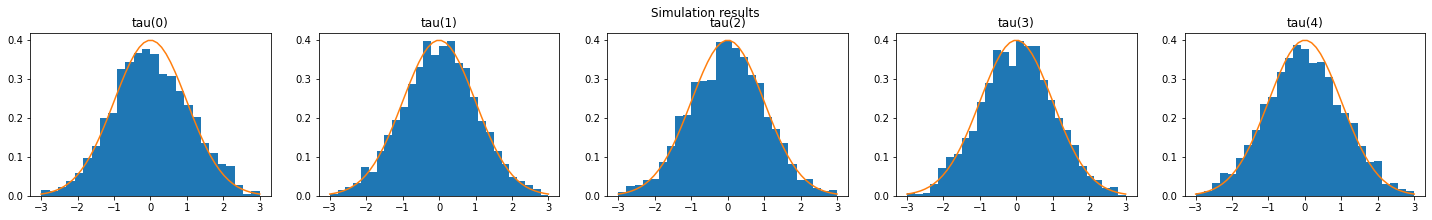

In [6]:
def simulate(n=100):
    return list(zip(*[one_trial() for i in range(n)]))


def plot(z, title):
    fig = plt.figure(figsize=(5*len(z),3))
    for i, zs in enumerate(z):
        plt.subplot(1, len(z), i+1)
        plt.hist(zs, range=(-3,3), density=True, bins='auto')
        x = np.linspace(-3,3)
        pdf = norm.pdf(x)
        plt.plot(x,pdf)
        plt.title("tau({})".format(i))
    plt.suptitle(title, y=1)
    plt.show()

results = simulate(2000)
with open('interference_simulation.pkl', 'wb') as fp:
    pickle.dump(results, fp)
plot(results, "Simulation results")

In [ ]:
def com_aipw_ols():
    Y, Z, X, labels = get_clustered_data(Ms=[5000,5000,2000], ns=[2,3,5])
    c = Clustered(Y, Z, X, labels)
    result1 = c.est_via_aipw()
    result2 = c.est_via_ols()
    gs = 1 + 0.1*np.sqrt(np.arange(5))
    return result1['beta(g)'] - gs, result2['beta(g)'] - gs

def simulate(n=10):
    return (list(zip(*[list(com_aipw_ols()[0]) for i in range(n)])), 
            list(zip(*[list(com_aipw_ols()[1]) for i in range(n)])))

def plot_comp(betas):
    fig = plt.figure(figsize=(5*len(betas[0]),3))
    plt.suptitle("AIPW", y=1)
    for i, bs in enumerate(betas[0]):
        plt.subplot(1, len(betas[0]), i+1)
        plt.hist(bs, density=True, bins='auto')
        plt.title("tau({})".format(i))
    plt.show()
    fig = plt.figure(figsize=(5*len(betas[0]),3))
    plt.suptitle("OLS", y=1)
    for i, bs in enumerate(betas[1]):
        plt.subplot(1, len(betas[1]), i+1)
        plt.hist(bs, density=True, bins='auto')
        plt.title("tau({})".format(i))
    plt.show()

results = simulate(2000)
with open('interference_simulation_ols_vs_aipw.pkl', 'wb') as fp:
    pickle.dump(results, fp)
plot_comp(results)